<a href="https://colab.research.google.com/github/Vigneshthanga/258-Deep-Learning/blob/master/Assignment-4/VGG16_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Required Libraries

In [0]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import _LRScheduler
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.nn import CrossEntropyLoss
from torch.optim import SGD
import numpy as np
from torch.autograd import Variable

## Define the model architecture in VGG16 class

In [0]:
cfg = {    
    'D' : [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']
}

class VGG(nn.Module):
    def __init__(self, features, num_class=100):
        super().__init__()
        self.features = features

        self.classifier = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_class)
        )

    def forward(self, x):
        output = self.features(x)
        output = output.view(output.size()[0], -1)
        output = self.classifier(output)
    
        return output

## Create additional layers

In [0]:
def make_layers(cfg, batch_norm=False):
    layers = []

    input_channel = 3
    for l in cfg:
        if l == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            continue

        layers += [nn.Conv2d(input_channel, l, kernel_size=3, padding=1)]

        if batch_norm:
            layers += [nn.BatchNorm2d(l)]
        
        layers += [nn.ReLU(inplace=True)]
        input_channel = l
    
    return nn.Sequential(*layers)

## Create the VGG16 Model

In [0]:
def vgg16_bn():
    return VGG(make_layers(cfg['D'], batch_norm=True))

## Get CIFAR 100 Train dataset

In [0]:
def train_dataloader(batch_size=16, num_workers=2, shuffle=True):
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor()
    ])
    cifar100_training = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
    cifar100_training_loader = DataLoader(
        cifar100_training, shuffle=shuffle, num_workers=num_workers, batch_size=batch_size)

    return cifar100_training_loader

## Get  CIFAR 100 Test dataset

In [0]:
def test_dataloader(batch_size=16, num_workers=2, shuffle=False):
    transform_test = transforms.Compose([
        transforms.Compose([transforms.ToTensor()])
    ])
    cifar100_test = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
    cifar100_test_loader = DataLoader(
        cifar100_test, shuffle=shuffle, num_workers=num_workers, batch_size=batch_size)

    return cifar100_test_loader

## Download CIFAR 100 Train dataset

In [80]:
trainloader = train_dataloader(num_workers=2, batch_size=64)

Files already downloaded and verified


## Download CIFAR 100 Test dataset

In [81]:
testloader = test_dataloader(num_workers=2, batch_size=64)

Files already downloaded and verified


## Get the model

In [0]:
net = vgg16_bn()

## Check if the Code is running on GPU if available

In [83]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Convert parameters and buffers to CUDA tensors

In [0]:
use_gpu = torch.cuda.is_available()
if use_gpu:
    net = net.to(device)

## Initialize Optimizers

In [0]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Train the model

In [86]:
for epoch in range(50):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i == 64:
            print('[Epoch %d, Batch %5d] loss: %.3f' %
                  (epoch + 1, i, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[Epoch 1, Batch    64] loss: 0.150
[Epoch 2, Batch    64] loss: 0.123
[Epoch 3, Batch    64] loss: 0.112
[Epoch 4, Batch    64] loss: 0.102
[Epoch 5, Batch    64] loss: 0.092
[Epoch 6, Batch    64] loss: 0.085
[Epoch 7, Batch    64] loss: 0.079
[Epoch 8, Batch    64] loss: 0.074
[Epoch 9, Batch    64] loss: 0.069
[Epoch 10, Batch    64] loss: 0.065
[Epoch 11, Batch    64] loss: 0.063
[Epoch 12, Batch    64] loss: 0.059
[Epoch 13, Batch    64] loss: 0.056
[Epoch 14, Batch    64] loss: 0.055
[Epoch 15, Batch    64] loss: 0.051
[Epoch 16, Batch    64] loss: 0.051
[Epoch 17, Batch    64] loss: 0.048
[Epoch 18, Batch    64] loss: 0.048
[Epoch 19, Batch    64] loss: 0.045
[Epoch 20, Batch    64] loss: 0.044
[Epoch 21, Batch    64] loss: 0.042
[Epoch 22, Batch    64] loss: 0.040
[Epoch 23, Batch    64] loss: 0.039
[Epoch 24, Batch    64] loss: 0.037
[Epoch 25, Batch    64] loss: 0.036
[Epoch 26, Batch    64] loss: 0.036
[Epoch 27, Batch    64] loss: 0.034
[Epoch 28, Batch    64] loss: 0.034
[

## Save the model

In [0]:
PATH = './cifar100_model_1.pth'
torch.save(net.state_dict(), PATH)

## Get the Actual Values

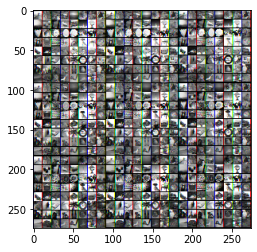

GroundTruth:  tensor(49) tensor(33) tensor(72) tensor(51)


In [88]:
import matplotlib.pyplot as plt
dataiter = iter(testloader)
#images, labels = dataiter.next()
images, labels = dataiter.next()
# print images
plt.figure()
plt.imshow(torchvision.utils.make_grid(images).reshape(274,274,3)) 
plt.show() 
#imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % labels[j] for j in range(4)))

In [89]:
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## Convert to CUDA Tensors

In [0]:
outputs = net(images.to(device))

## Get the predicted Labels

In [91]:
_, predicted = torch.max(outputs.data, 1)
for i in range(4):
  print(predicted[i])

tensor(90, device='cuda:0')
tensor(33, device='cuda:0')
tensor(55, device='cuda:0')
tensor(51, device='cuda:0')


## Get the Accuracy

In [92]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 60 %
